# Deep Linear Networks

In [31]:
from typing import Optional, Union, List
from dataclasses import dataclass, field
import itertools

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
class DLN(nn.Module):
    """A deep linear network with L layers."""

    def __init__(self, dims: List[int], init_variance: float = 1.0):
        super().__init__()
        self.dims = dims
        self.L = len(dims) - 1
        self.init_variance = init_variance
        self.linears = nn.ModuleList([nn.Linear(d1, d2, bias=False) for d1, d2 in zip(dims[:-1], dims[1:])])

        # Initialize weights and biases
        for l in range(self.L):
            self.linears[l].weight.data.normal_(0, self.init_variance)  # Note: this is not normalized by the input dimension

    def forward(self, x):
        for l in range(self.L):
            x = self.linears[l](x)
        return x
    
    def __repr__(self):
        return f"DLN({self.dims})"
    
    @classmethod
    def make_rectangular(cls, input_dim: int, output_dim: int, L: int, w: int, gamma: float):
        """Make a rectangular DLN with L layers and width w."""
        init_variance = w ** (-gamma)
        return cls([input_dim] + [w] * (L-1) + [output_dim], init_variance=init_variance)
    
    def to_matrix(self):
        """Return the matrix representation of the DLN."""
        return self.forward(torch.eye(self.dims[0]))

    @classmethod
    def from_matrix(cls, A):
        """Construct a DLN from a matrix."""
        dims = [A.shape[0], A.shape[1]]
        dln = cls(dims)
        dln.linears[0].weight.data = A

        return dln
    
    def rank(self):
        """Return the rank of the DLN."""
        return torch.linalg.matrix_rank(self.to_matrix())
    
    def norm(self, p: Union[int, float, str]=2):
        """Return the nuclear norm of the DLN."""
        return torch.norm(self.to_matrix(), p=p)
    
    def grad_norm(self, p=2):
        """Return the norm of the gradient of the DLN."""
        grad_norm = torch.zeros(1)

        if p != 2:
            raise NotImplementedError("Only p=2 is implemented.")

        for l in range(self.L):
            grad_norm += torch.sum(self.linears[l].weight.grad ** p)
            
        return grad_norm ** (1/p)


In [3]:
# Attempt to reproduce Figure 1 of Jacot et al.
np.random.seed(42)

A_true = torch.Tensor(np.random.randn(10, 3) @ np.random.randn(3, 10))

def matrix_completion_loss(A1: torch.Tensor, A2: torch.Tensor, indices: Union[torch.Tensor, np.ndarray]):
    """
    Weird loss that Jacot et al. used. I couldn't get this to work, so ignore it. 
    $\frac{1}{N} \sum_{i=1}^N\left(A_{k_i, m_i}-A_{k_i, m_i}^*\right)^2$ for some true matrix $A^*$ of which we observe only the $N$ entries $A_{k_1, m_1}^*, \ldots, A_{k_N, m_N}^*$.
    """    
    return torch.mean((A1[indices[:, 0], indices[:, 1]] - A2[indices[:, 0], indices[:, 1]])**2)

def train_test_split(indices, test_size=0.2, random_state=None):
    """Split indices into train and test set."""
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.permutation(indices)
    split_index = int((1 - test_size) * len(indices))
    return (indices[:split_index]), (indices[split_index:])

all_indices = np.array([(i, j) for i in range(10) for j in range(10)])
train_indices, test_indices = train_test_split(all_indices, test_size=0.8, random_state=42)

def _train_loss(A):
    #A_true_with_noise = torch.Tensor(np.random.randn(10, 10) * 0.2) + A_true
    # return matrix_completion_loss(A, A_true_with_noise, train_indices)
    return matrix_completion_loss(A, A_true, train_indices)

def _test_loss(A):
    return matrix_completion_loss(A, A_true, test_indices)

model = DLN.make_rectangular(10, 10, 4, 100, 2.)
optim = torch.optim.SGD(model.parameters(), lr=1e-4) #, weight_decay=1e-4, momentum=0.9)

train_losses = []
test_losses = []

model.train()

# for i in tqdm(range(10_000), desc="Fitting..."):
#     optim.zero_grad()
#     loss = _train_loss(model.to_matrix())
#     loss.backward()
#     optim.step()

#     train_losses.append(loss.item())

#     with torch.no_grad():
#         test_losses.append(_test_loss(model.to_matrix()))

# plt.plot(train_losses, label='train')
# plt.plot(test_losses, label='test')
# plt.legend()
    

DLN([10, 100, 100, 100, 10])

In [26]:
# From https://github.com/edmundlth/scalable_learning_coefficient_with_sgld/blob/v1.0/experiment.py

from copy import deepcopy

def individual_losses(model, dataloader):
    losses = np.zeros(len(dataloader.dataset))

    for i, (inputs, labels) in enumerate(dataloader):
        outputs = model(inputs)
        losses[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = np.mean(((outputs-labels)**2).detach().numpy(), axis=1)

    return losses

@dataclass
class SGLDChain:
    runs: List[np.ndarray]
    

@dataclass
class SGLDRun:
    chains: SGLDChain
    local_free_energy: float
    lambda_hat: float
    nu_hat: float


def estimate_rlct(
    model, trainloader, num_iter=100, num_chains=1, gamma=None, epsilon=1e-5, verbose=True
):
    num_training_samples = len(trainloader.dataset)
    gamma_dict = {}
    
    if gamma is None:
        with torch.no_grad():
            for name, param in model.named_parameters():
                gamma_val = 100.0 / np.linalg.norm(param)
                gamma_dict[name] = gamma_val

    loss_sum = np.zeros(num_training_samples)
    loss_sum_sq = np.zeros(num_training_samples)
    energy = 0

    chain_Lms = []
    model.zero_grad()

    for chain in range(num_chains):
        model_copy = deepcopy(model)
        model_copy.train()
        og_params = deepcopy(dict(model_copy.named_parameters()))
        Lms = []

        for i, (inputs, labels) in zip(range(num_iter), itertools.cycle(trainloader)):
            with torch.no_grad():
                losses = individual_losses(model_copy, trainloader)
                loss_sum += losses
                loss_sum_sq += losses * losses

                if i == 0:
                    energy = np.sum(losses)
                
            # call a minibatch loss backward
            # so that we have gradient of average minibatch loss with respect to w'

            outputs = model_copy(inputs)
            loss_ = F.mse_loss(outputs, labels)
            loss_.backward(retain_graph=True)

            # TODO: Put this in an optimizer
            for name, w in model_copy.named_parameters():
                w_og = og_params[name]
                dw = -w.grad.data / np.log(num_training_samples) * num_training_samples

                if gamma is None:
                    prior_weight = gamma_dict[name]
                else:
                    prior_weight = gamma

                dw.add_(w.data - w_og.data, alpha=-prior_weight)
                w.data.add_(dw, alpha=epsilon / 2)
                gaussian_noise = torch.empty_like(w)
                gaussian_noise.normal_()
                w.data.add_(gaussian_noise, alpha=np.sqrt(epsilon))
                w.grad.zero_()

            Lms.append(loss_.item())
        chain_Lms.append(Lms)
        
        if verbose:
            print(f"Chain {chain + 1}: L_m = {np.mean(Lms)}")

    chain_Lms = np.array(chain_Lms)
    local_free_energy = num_training_samples * np.mean(chain_Lms)
    chain_std = np.std(num_training_samples * np.mean(chain_Lms, axis=1))        

    # variance = (loss_sum_sq - loss_sum * loss_sum / m) / (m - 1)
    # func_var = float(np.sum(variance))
    hat_lambda = (local_free_energy - energy) / np.log(num_training_samples)
    
    if verbose:
        print(
            f"LFE: {local_free_energy} (std: {chain_std}, n_chain={num_chains}, hat_lambda={hat_lambda}, energy={energy})"
        )

    return hat_lambda

In [29]:

@dataclass
class Run:
    gamma: float = 1.
    w: int = 100
    L: int = 4
    input_dim: int = 5
    output_dim: int = 5
    seed: int = 0
    num_steps: int = 50_000
    lr: float = 1e-4
    student: Optional[DLN] = None
    train_errors: Optional[np.ndarray] = None
    test_errors: Optional[np.ndarray] = None
    ranks: Optional[np.ndarray] = None
    nuc_norms: Optional[np.ndarray] = None
    grad_norms: Optional[np.ndarray] = None

teacher_matrix = torch.Tensor(10 * np.diag(np.arange(1, 6)))
teacher = DLN.from_matrix(teacher_matrix)

def gen_data(num_samples: int, num_features: int):
    inputs = torch.rand(num_samples, num_features)
    labels = teacher(inputs)
    return torch.utils.data.TensorDataset(inputs, labels)

train_data = gen_data(100, 5)
test_data = gen_data(100, 5)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

model = DLN.make_rectangular(5, 5, w=10, L=4, gamma=1.5)
estimate_rlct(model, train_loader, verbose=True)

def fit(train_loader, **kwargs) -> Run:
    train_data = train_loader.dataset
    run = Run(**kwargs)

    if run.student is None:
        run.student = DLN.make_rectangular(run.input_dim, run.output_dim, w=run.w, L=run.L, gamma=run.gamma)

    student = run.student
    optim = torch.optim.SGD(student.parameters(), lr=run.lr, momentum=0.9, weight_decay=1e-4)

    train_errors = []
    test_errors = []
    ranks = []
    nuc_norms = []
    grad_norms = []
    rlcts = []

    for i in tqdm(range(run.num_steps), desc="Training"):
        optim.zero_grad()
        loss = F.mse_loss(student(train_data.tensors[0]), train_data.tensors[1])
        loss.backward(retain_graph=True)
        optim.step()

        # if i % 100 == 0 or i < 2000:
        train_errors.append(loss.detach().numpy())
        ranks.append(student.rank().detach().numpy())   
        nuc_norms.append(student.norm(p="nuc").detach().numpy())
        grad_norms.append(student.grad_norm().detach().numpy())

        if i % 100 == 0:
            rlcts.append(estimate_rlct(student, train_loader, verbose=False, num_iter=1000))

        # with torch.no_grad():
        #     test_errors.append(F.mse_loss(student(test_data.tensors[0]), test_data.tensors[1]).detach().numpy())

    run.train_errors = np.array(train_errors)
    run.test_errors = np.array(test_errors)
    run.ranks = np.array(ranks)
    run.nuc_norms = np.array(nuc_norms)
    run.grad_norms = np.array(grad_norms)
    run.rlcts = np.array(rlcts)

    return run

sample_run = fit(train_loader, num_steps=10_000, w=10, L=4, gamma=1.5, lr=1e-4)

Chain 1: L_m = 364.40434173583986
LFE: 36440.434173583984 (std: 0.0, n_chain=1, hat_lambda=-0.003929697078989079, energy=36440.45227050781)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

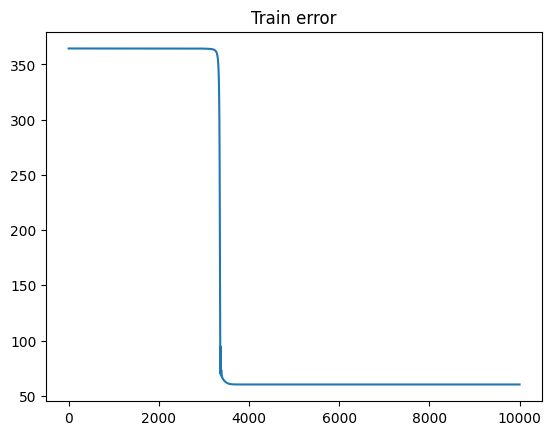

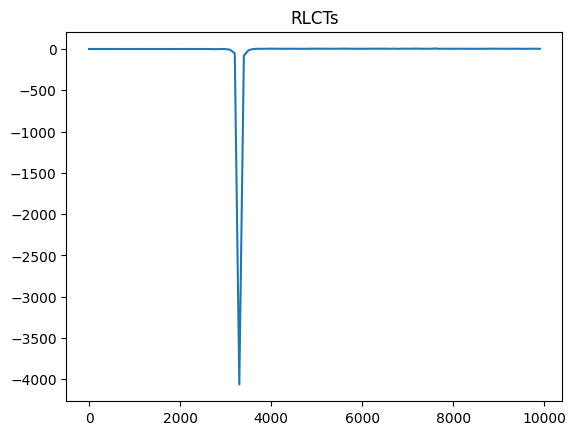

In [30]:
plt.title("Train error")
plt.plot(np.arange(10_000), sample_run.train_errors, label="Train")
plt.show()

plt.title("RLCTs")
plt.plot(np.arange(0, 10_000, 100), sample_run.rlcts, label="RLCT")
plt.show()

In [ ]:


@dataclass
class Runs:
    runs: List[Run] = field(default_factory=list)

    def filter(self, **kwargs):
        return Runs([run for run in self.runs if self.matches(run, **kwargs)])

    @staticmethod
    def matches(run, **kwargs):
        return all([getattr(run, k) == v for k, v in kwargs.items()])
    
    def __iter__(self):
        return iter(self.runs)
    
    def __len__(self):
        return len(self.runs)
    
    def __getitem__(self, i):
        return self.runs[i]
    
    def __repr__(self):
        return f"Runs({self.runs})"
    
    def __add__(self, other):
        return Runs(self.runs + other.runs)
    
    def __iadd__(self, other):
        self.runs += other.runs
        return self
    
    def append(self, run):
        self.runs.append(run)

runs = Runs()


# Define a unique set of gammas
gammas = [0.75, 1., 1.5]
ws = [10, 100]

for gamma, w in tqdm(list(itertools.product(gammas, ws)), desc="Sweeping"):
    runs.append(fit(train_loader, gamma=gamma, w=w))


Sweeping:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


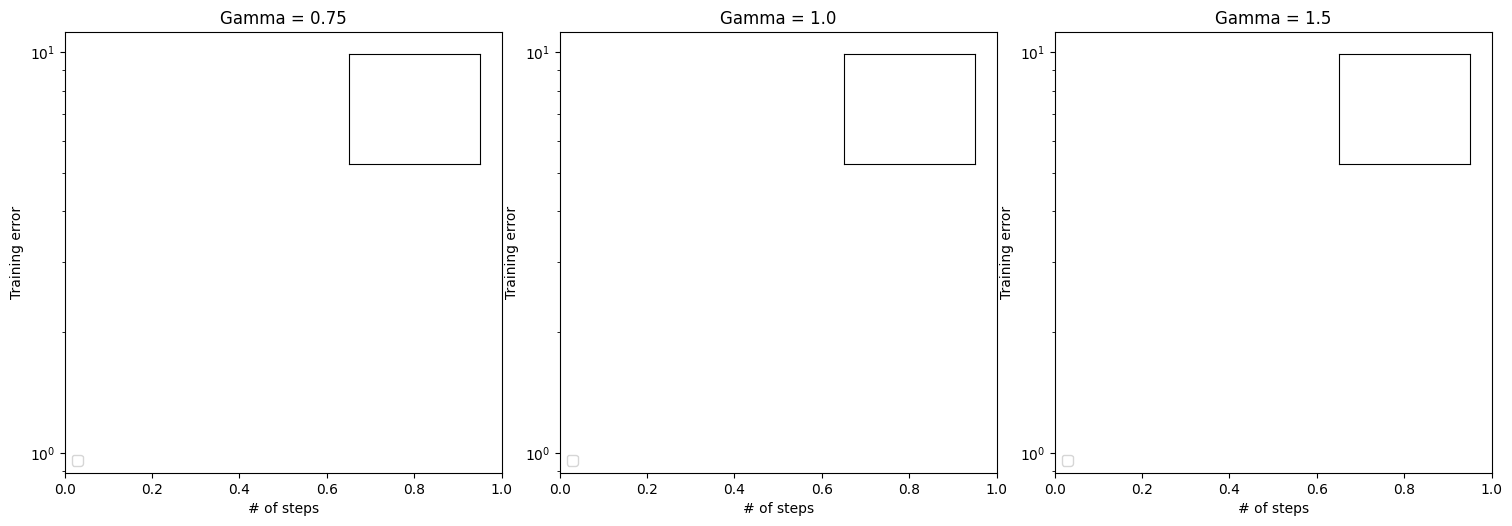

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


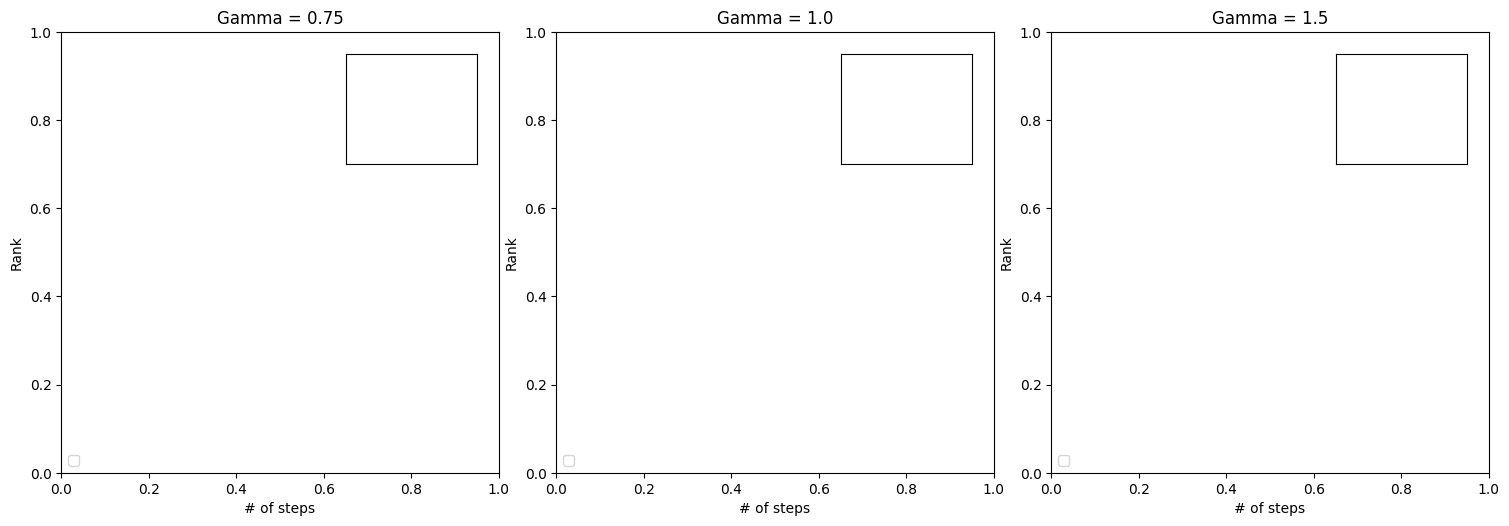

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


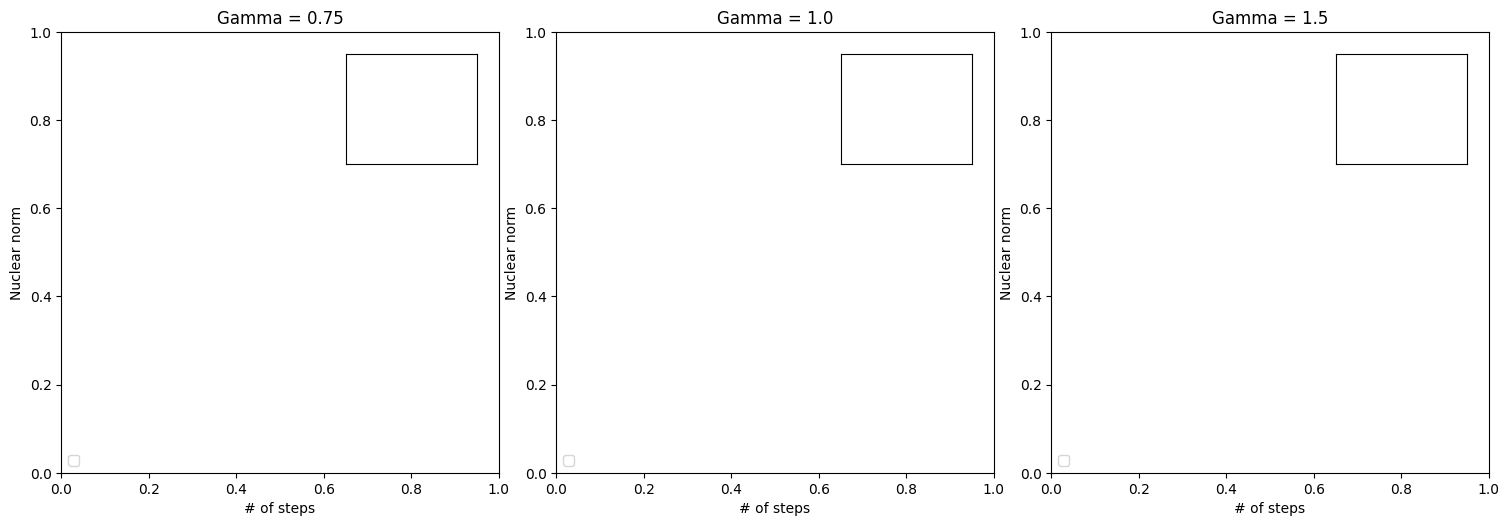

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


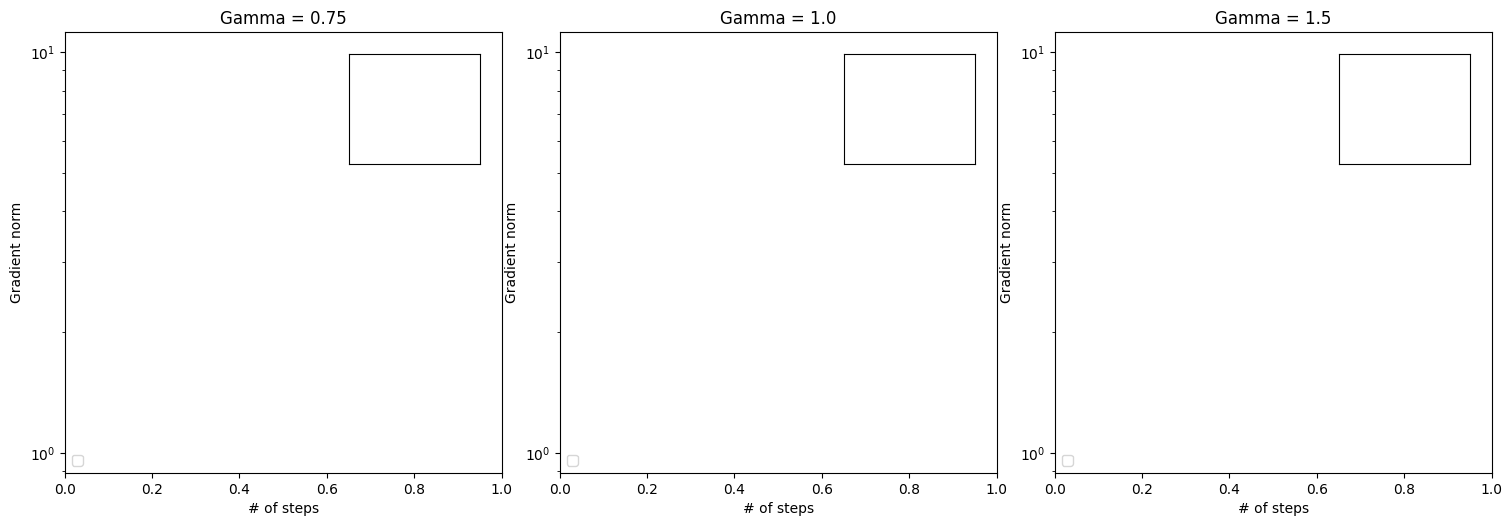

In [ ]:
import matplotlib.pyplot as plt

def plot(runs: Runs, metric: str, ylabel: str, title: str, logscale: bool = False):

    # Define the colors for each w value
    colors = {10: 'b', 100: 'g'}

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    fig.tight_layout()


    # Iterate through the unique gammas
    for i, gamma in enumerate(gammas):
        ax = axes[i]
        # Add an inset focusing on the first 2000 steps
        ax_inset = ax.inset_axes([0.65, 0.7, 0.3, 0.25])

        # Iterate through the runs, filtering by the current gamma
        for run in runs.filter(gamma=gamma):
            values = getattr(run, metric)
            w = run.w
            color = colors[w]
            
            # Plot the training error against the number of steps
            ax.plot(values, color=color, label=f'w={w}')
            ax_inset.plot(values[:2000], color=color)
        
        ax_inset.yaxis.set_visible(False)
        ax_inset.xaxis.set_visible(False)
        ax.set_xlabel('# of steps')
        ax.set_ylabel(ylabel)
        
        if logscale:
            ax_inset.set_yscale('log')
            ax.set_yscale('log')

        ax.set_title(f'Gamma = {gamma}')
        ax.legend(loc='lower left') 

    plt.show()

plot(runs, 'train_errors', 'Training error', 'Training error', logscale=True)
# plot(runs, 'test_errors', 'Test error', 'Test error', logscale=True)
plot(runs, 'ranks', 'Rank', 'Rank', logscale=False)
plot(runs, 'nuc_norms', 'Nuclear norm', 'Nuclear norm', logscale=False)
plot(runs, 'grad_norms', 'Gradient norm', 'Gradient norm', logscale=True)